# 背景
attention机制最早在NLP领域，在训练中增加一个逻辑计算针对权重的机制，提高对目标有关参数的权重，降低对目标无关的权重。2018年[CBMA](https://arxiv.org/abs/1807.06521)提出卷积网络中的注意力机制，包括一维的channel attention和二维的spatial attention两个部分。

In [1]:
from mxnet.gluon import data as gdata, nn
from mxnet import contrib, image, nd,gluon,autograd, init
import os,sys
import mxnet as mx
from mxnet import gluon, nd

C:\Users\001\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 32
ctx = mx.gpu()

resize=(32,32)

if not os.path.exists('output'):
    os.makedirs('output')

save_prefix = "output/attention"

# 使用FasionMNIST做测试数据

In [37]:
import numpy as np
def load_mnist(batch_size, resize = None):
    mnist_train = gdata.vision.FashionMNIST(train=True)
    mnist_test = gdata.vision.FashionMNIST(train=False)

    transformer_train, transformer_test = [],[]
    if resize:
        transformer_train.append(gdata.vision.transforms.Resize(resize))
        transformer_test.append(gdata.vision.transforms.Resize(resize))
    transformer_train.append(gdata.vision.transforms.RandomFlipLeftRight()) #没做flip，train acc 92% test acc 91%
    transformer_train += [gdata.vision.transforms.ToTensor()]
    transformer_train = gdata.vision.transforms.Compose(transformer_train)
    
    transformer_test += [gdata.vision.transforms.ToTensor()]
    transformer_test = gdata.vision.transforms.Compose(transformer_test)
    num_worker = 0 if sys.platform.startswith("win32") else 2
    train_iter = gdata.DataLoader(mnist_train.transform_first(transformer_train),batch_size,shuffle=True,
                                  last_batch="rollover",num_workers=num_worker)
    test_iter = gdata.DataLoader(mnist_test.transform_first(transformer_test),batch_size,shuffle=False,
                                 last_batch="rollover",num_workers=num_worker)
    return train_iter,test_iter,len(mnist_train)

def get_class_names():
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return text_labels

train_iter,valid_iter,num_trainset = load_mnist(batch_size,resize)
num_classes = len(get_class_names())

print('#. trainset ',num_trainset)


#. trainset  60000


# 定义网络
Q：如果conv_bn_relu()中是包含一个Conv-bn层，则训练中十分容易遇到NaN问题     
Q: 两个不使用非线性激励函数的FC层，训练中容易得到NaN     
   其中之一使用激励函数relu后，初始化采用normal(0.5)依然容易输出很大/很小的值，导致nan；但把normal(0.5)替换成xavier至少第一轮可以避免nan.
   但如果此时conv_bn_relu()中卷积层减少到1时，依然容易导致NaN问题。尝试过交换BN层和Activation层次序，没有改善。   
* 结论：这样一个浅网络，BN层未必起到规则化的作用?

In [106]:

def conv_bn_relu(channel,kernel,stride,padding):
    net = nn.Sequential()
    net.add(
        nn.Conv2D(channel, kernel, strides=stride, padding=padding),       
        #nn.BatchNorm(),
        nn.Activation("relu"),
        
        nn.Conv2D(channel, kernel, strides=stride, padding=padding),
        #nn.BatchNorm(),
        nn.Activation("relu"),
    )
    return net

class BASENET(nn.Block):
    def __init__(self, num_classes):
        super(BASENET,self).__init__()
        self.stages = nn.Sequential()
        self.stages.add(
            conv_bn_relu(32,5,2,2),
            nn.MaxPool2D(2),
            conv_bn_relu(64,3,1,1),
            nn.MaxPool2D(2),
            conv_bn_relu(128,3,1,1),
            nn.MaxPool2D(2),
            nn.GlobalMaxPool2D(),
            #nn.Dense(256), #BN层在浅网络中反而导致梯度爆炸？
            #nn.Dense(256),
            #nn.Dropout(0.5),
            nn.Dense(128),
            nn.Dense(num_classes)
        )
        return
    def forward(self, X):
        Y = self.stages(X)

        return Y
    
    
class ATTNET(nn.Block): #通道AM
    def __init__(self, num_classes):
        super(ATTNET,self).__init__()
        self.stageA, self.stageB, self.stageC = nn.Sequential(),nn.Sequential(),nn.Sequential()
        self.stageD, self.stageE = nn.Sequential(),nn.Sequential()
        self.stageA.add(
            conv_bn_relu(32,5,2,2),
            nn.MaxPool2D(2),
            conv_bn_relu(64,3,1,1),
            nn.MaxPool2D(2)
        )
        self.stageB.add(
            nn.GlobalMaxPool2D(),
            nn.Dense(32, activation="relu"),
            nn.Dense(64, activation="sigmoid") #mxnet 支持sigmoid？
        )
        self.stageC.add(
            nn.GlobalAvgPool2D(),
            nn.Dense(32, activation="relu"),
            nn.Dense(64, activation="sigmoid") #mxnet 支持sigmoid？
        )
        self.stageD.add(
            nn.Dense(32, activation="relu"),
            nn.Dense(64, activation="sigmoid") #mxnet 支持sigmoid？
        )
        self.stageE.add(
            conv_bn_relu(128,3,1,1),
            nn.MaxPool2D(2),
            nn.GlobalMaxPool2D(),
            nn.Dense(128),
            #nn.Dropout(0.5),
            #nn.Dense(128),
            nn.Dense(num_classes)
        )
        return 
    
    def forward(self,X):
        Ya = self.stageA(X)
        Yb = self.stageB(Ya) 
        Yc = self.stageC(Ya)
        Ybc = self.stageD(Yb+Yc)
        Ybc = nd.reshape(Ybc,(0,0,1,1)) #apply attention
        Y = self.stageE(Ya*Ybc)
        return Y
        
    

# 训练

In [ ]:
import time



def test_net(net, valid_iter, ctx):
    cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    cls_acc = mx.metric.Accuracy(name="test acc")
    loss_sum = []
    for batch in valid_iter:
        X,Y = batch
        out = X.as_in_context(ctx)
        out = net(out)
        out = out.as_in_context(mx.cpu())
        cls_acc.update(Y,out)
        loss = cls_loss(out, Y)
        loss_sum.append( loss.mean().asscalar() )
    print("\ttest loss {} {}".format( np.mean(loss_sum),cls_acc.get()))
    return cls_acc.get_name_value()[0][1], np.mean(loss_sum)


def train_net(net, train_iter, valid_iter, batch_size, trainer, ctx, num_epochs, lr_sch, save_prefix, train_log):
    cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
    cls_acc = mx.metric.Accuracy(name="train acc")
    top_acc = 0
    iter_num = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = [], 0
        t0 = time.time()
        trainer.set_learning_rate(lr_sch(epoch))
        for batch in train_iter:
            iter_num += 1
            X,Y = batch
            out = X.as_in_context(ctx)
            with autograd.record(True):
                out = net(out)
                out = out.as_in_context(mx.cpu())
                loss = cls_loss(out, Y)
            loss.backward()
            train_loss.append( loss.mean().asscalar() )
            #print(loss.mean().asscalar())
            trainer.step(batch_size)
            cls_acc.update(Y,out)
            nd.waitall()

        print("epoch {} lr {} {}sec".format(epoch,trainer.learning_rate, time.time() - t0))
        train_loss,train_acc = np.mean(train_loss), cls_acc.get_name_value()[0][1]
        print("\ttrain loss {} {}".format( np.mean(train_loss), cls_acc.get()))
        acc,test_loss = test_net(net, valid_iter, ctx)
        test_acc = acc
        train_log.append((train_loss, train_acc, test_loss, test_acc))
        
        if top_acc < acc:
            top_acc = acc
            print('\ttop valid acc {}'.format(acc))
            if isinstance(net, mx.gluon.nn.HybridSequential) or isinstance(net, mx.gluon.nn.HybridBlock):
                pf = '{}_{:.3f}.params'.format(save_prefix,top_acc)
                net.export(pf,epoch)
            else:
                net_path = '{}top_acc_{}_{:.3f}.params'.format(save_prefix,epoch,top_acc)
                net.save_parameters(net_path)
       

from mxnet import lr_scheduler
num_epochs = 30
logs = {0:[], 1:[]}
for ind,net in enumerate([ ATTNET(num_classes),BASENET(num_classes)]):
    net.initialize(init=init.Xavier(), ctx=ctx)
    #net.initialize(init=init.Normal(0.5),ctx=ctx)
    #trainer = gluon.Trainer(net.collect_params(), 'sgd',{'wd': 5e-4,"momentum":0.9,"clip_gradient":10})
    #trainer = gluon.Trainer(net.collect_params(), 'sgd',{'wd': 5e-4,"momentum":0.9})
    trainer = gluon.Trainer(net.collect_params(), 'sgd',{'wd': 5e-4})
    lr_sch = lr_scheduler.FactorScheduler(step=10, factor=0.1)
    lr_sch.base_lr = 0.2
    train_net(net, train_iter, valid_iter, batch_size, trainer, ctx, num_epochs, lr_sch, save_prefix,logs[ind])


epoch 0 lr 0.2 42.24735713005066sec
	train loss 0.7450331449508667 ('train acc', 0.7178666666666667)
	test loss 0.4256230890750885 ('test acc', 0.8471554487179487)
	top valid acc 0.8471554487179487
epoch 1 lr 0.2 41.316762924194336sec
	train loss 0.3948751389980316 ('train acc', 0.7859833333333334)
	test loss 0.3850254714488983 ('test acc', 0.8533346645367412)
	top valid acc 0.8533346645367412
epoch 2 lr 0.2 41.236796140670776sec
	train loss 0.3428177535533905 ('train acc', 0.8147055555555556)
	test loss 0.3435649275779724 ('test acc', 0.8734975961538461)
	top valid acc 0.8734975961538461
epoch 3 lr 0.2 40.847827196121216sec
	train loss 0.3159172236919403 ('train acc', 0.8319708333333333)
	test loss 0.32022878527641296 ('test acc', 0.8790934504792333)
	top valid acc 0.8790934504792333
epoch 4 lr 0.2 40.86844205856323sec
	train loss 0.29972660541534424 ('train acc', 0.8431166666666666)
	test loss 0.30280259251594543 ('test acc', 0.8848157051282052)
	top valid acc 0.8848157051282052
epoc

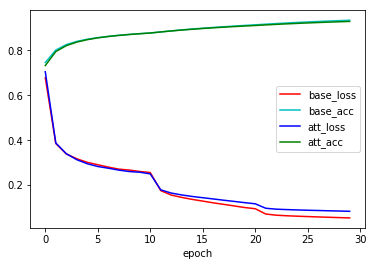

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt


base_loss = [L[0] for L in logs[1]]
base_acc = [L[1] for L in logs[1]]
att_loss = [L[0] for L in logs[0]]
att_acc = [L[1] for L in logs[0]]

epochs = [k for k in range(num_epochs)]
plt.plot(epochs, base_loss, color='r', label='base_loss')
plt.plot(epochs, base_acc, color='c', label='base_acc')
plt.plot(epochs, att_loss, color='b', label='att_loss')
plt.plot(epochs, att_acc, color='g', label='att_acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

